# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [6]:
print(train_stats)
df.head()

    count        mean        std     min     25%     50%     75%     max
X1  614.0    0.761661   0.105539    0.62    0.66    0.74    0.82    0.98
X2  614.0  673.829805  88.172315  514.50  612.50  686.00  759.50  808.50
X3  614.0  319.617264  43.435568  245.00  294.00  318.50  343.00  416.50
X4  614.0  177.106270  45.077034  110.25  147.00  220.50  220.50  220.50
X5  614.0    5.232899   1.751343    3.50    3.50    3.50    7.00    7.00
X6  614.0    3.478827   1.134671    2.00    2.00    3.00    5.00    5.00
X7  614.0    0.237296   0.134236    0.00    0.10    0.25    0.40    0.40
X8  614.0    2.815961   1.564389    0.00    1.00    3.00    4.00    5.00


,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.82,612.5,318.5,147.0,7.0,2,0.40,1,29.22,31.71
1,0.71,710.5,269.5,220.5,3.5,5,0.10,1,10.75,14.27
2,0.86,588.0,294.0,147.0,7.0,2,0.10,5,27.03,25.82
3,0.66,759.5,318.5,220.5,3.5,5,0.40,2,15.30,18.15
4,0.64,784.0,343.0,220.5,3.5,2,0.25,2,17.14,20.47


## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [5]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

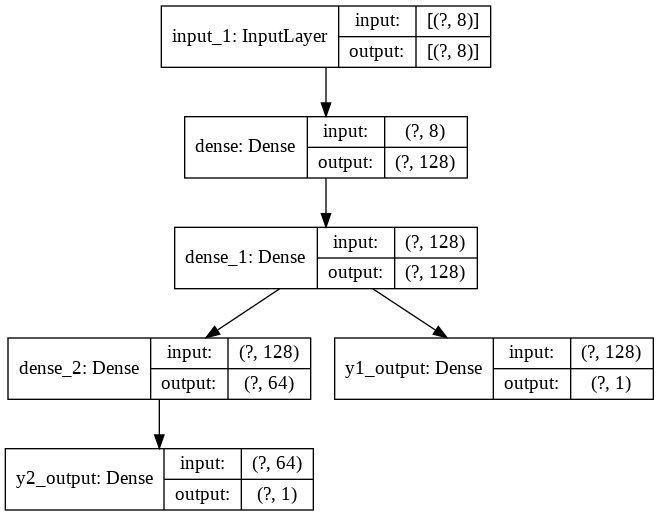

In [8]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [7]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [9]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 251.2068 - y1_output_loss: 115.0048 - y2_output_loss: 134.8394 - y1_output_root_mean_squared_error: 10.7614 - y2_output_root_mean_squared_error: 11.6361 - val_loss: 170.4220 - val_y1_output_loss: 30.3846 - val_y2_output_loss: 138.3492 - val_y1_output_root_mean_squared_error: 5.5311 - val_y2_output_root_mean_squared_error: 11.8249
Epoch 2/500
614/614 [==============================] - 0s 172us/sample - loss: 41.1131 - y1_output_loss: 14.1455 - y2_output_loss: 26.8309 - y1_output_root_mean_squared_error: 3.7538 - y2_output_root_mean_squared_error: 5.1983 - val_loss: 36.0559 - val_y1_output_loss: 11.7283 - val_y2_output_loss: 23.7598 - val_y1_output_root_mean_squared_error: 3.4592 - val_y2_output_root_mean_squared_error: 4.9081
Epoch 3/500
614/614 [==============================] - 0s 148us/sample - loss: 41.1641 - y1_output_loss: 13.2908 - y2_output_loss: 27.6604 - y

## Evaluate the Model and Plot Metrics

In [10]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 34us/sample - loss: 2.9975 - y1_output_loss: 0.3163 - y2_output_loss: 2.7145 - y1_output_root_mean_squared_error: 0.5577 - y2_output_root_mean_squared_error: 1.6390
Loss = 2.99745841769429, Y1_loss = 0.31627899408340454, Y1_mse = 0.5577295422554016, Y2_loss = 2.7145028114318848, Y2_mse = 1.639022946357727


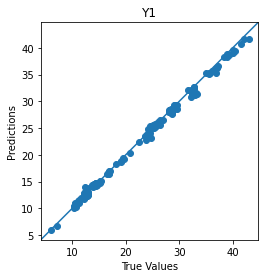

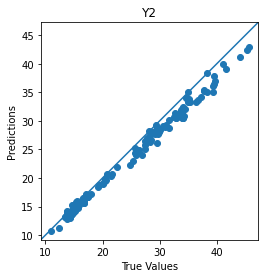

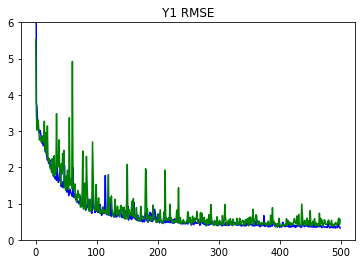

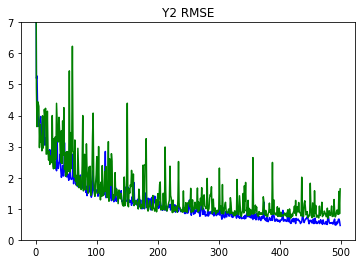

In [11]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)